# Bias and Fairness Metrics Lab and Assignment Notebook

In this lab, we will explore the concept of bias in models and datasets, with a focus on identifying and mitigating fairness issue. Bias in machine learning can arise due to imbalances in the data, societal inequities, or algorithmic processing, and it can have significant consequences in real-world applications, such as lending decisions, hiring processes, or healthcare recommendations.

Using IBM's AIF360 re-weighing and the disparate impact remover (DIR) you will investigate how modifying a dataset can improve fairness metrics while assessing its potential trade-offs. We will be using a credit card default dataset where we will:

**Lab Portion:**
1. Quantify dataset bias: by calculating fairness metrics such as Statistical Parity Difference (SPD), Equal Opportunity Difference (EOD), and Disparate Impact (DI).
2. Mitigate Bias: using AIF360's reweighing or DIR.
3. Analyze trade-offs.

*Adapted from: Masis, S. (2021). Chapter 11: Bias Mitigation and Causal Inference Methods. In Interpretable machine learning with Python: Learn to build interpretable high-performance models with hands-on real-world examples. Packt Publishing.

**Assignment Portion:**
1. Experimentation with the DIR
2. Reflection Questions

## Dataset Introduction: Adapted Taiwan Credit Card Default Prediction

The dataset used in this lab is an adapted version of the Taiwan Credit Card Default Prediction Dataset, which contains information on 30,000 credit card clients in Taiwan. It is commonly used in machine learning to study credit risk analysis, as well as fairness and bias in predictive modeling.

The dataset includes a mix of demographic, financial, and behavioral variables, along with a target variable that indicates whether a client defaulted on their credit card payment in the following month. Here's an overview of the key features:

<b>Demographic Variables:</b>
- AGE: The age of the client.
- SEX: The gender of the client (Male: 1, Female: 2).
- EDUCATION: The highest level of education attained (e.g., Graduate, University, High School).
- MARRIAGE: The marital status of the client (e.g., Married, Single, Other).

<b>Financial Variables:</b>
- LIMIT_BAL: The credit limit assigned to the client.
- BILL_AMT1 to BILL_AMT6: The amount of the bill statement for the past six months.
- PAY_AMT1 to PAY_AMT6: The payment amount for the past six months.

<b>Behavioral Variables:</b>
- PAY_0 to PAY_6: The repayment status for the past six months (e.g., fully paid, delayed).

<b>Target Variable:</b>
- default payment next month: Whether the client defaulted on their payment in the next month (1 for default, 0 for no default).

In [1]:
!pip install aif360
!pip install fairlearn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, accuracy_score
from aif360.metrics import ClassificationMetric
import lightgbm as lgb
from lightgbm import LGBMClassifier
from tqdm import tqdm
from aif360.algorithms.preprocessing import DisparateImpactRemover
import warnings
warnings.filterwarnings("ignore")


pip install 'aif360[inFairness]'


In [3]:


from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AAI-531/credit_card_default_531v.1.csv')

# Now you can work with the dataframe 'df'
print(data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146   

In [4]:
# structure and data types
data.info()

# missing values check
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

# unique values in columns related to gender <- dataset uses 1 for male and 2 for female
print("Unique values in 'SEX':", data['SEX'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [5]:
# Rename only the target column for consistency
data.rename(columns={"default payment next month": "DEFAULT_NEXT_MONTH"}, inplace=True)

In [6]:
# encode SEX column: Male = 1, Female = 0 (already numeric, we are just replace 2 with 0)
data["SEX"] = data["SEX"].replace({2: 0})  # Male = 1, Female = 0

#EDUCATION: Map numbers to clear numeric categories for interpretability
#Graduate = 1, University = 2, High School = 3, Other = 4
data["EDUCATION"] = data["EDUCATION"].replace({
    0: 4,  # Map 0 to 'Other'
    1: 1,  # Graduate
    2: 2,  # University
    3: 3,  # High School
    4: 4,  # Other
    5: 4,  # Other
    6: 4   # Other
})

#MARRIAGE: Map numbers to clear numeric categories for interpretability
#Married = 1, Single = 2, Other = 3
data["MARRIAGE"] = data["MARRIAGE"].replace({
    0: 3,  # Map 0 to 'Other'
    1: 1,  # Married
    2: 2,  # Single
    3: 3   # Other
})

In [7]:
columns_to_keep = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "DEFAULT_NEXT_MONTH"]
data_subset = data[columns_to_keep]

## Data Exploration

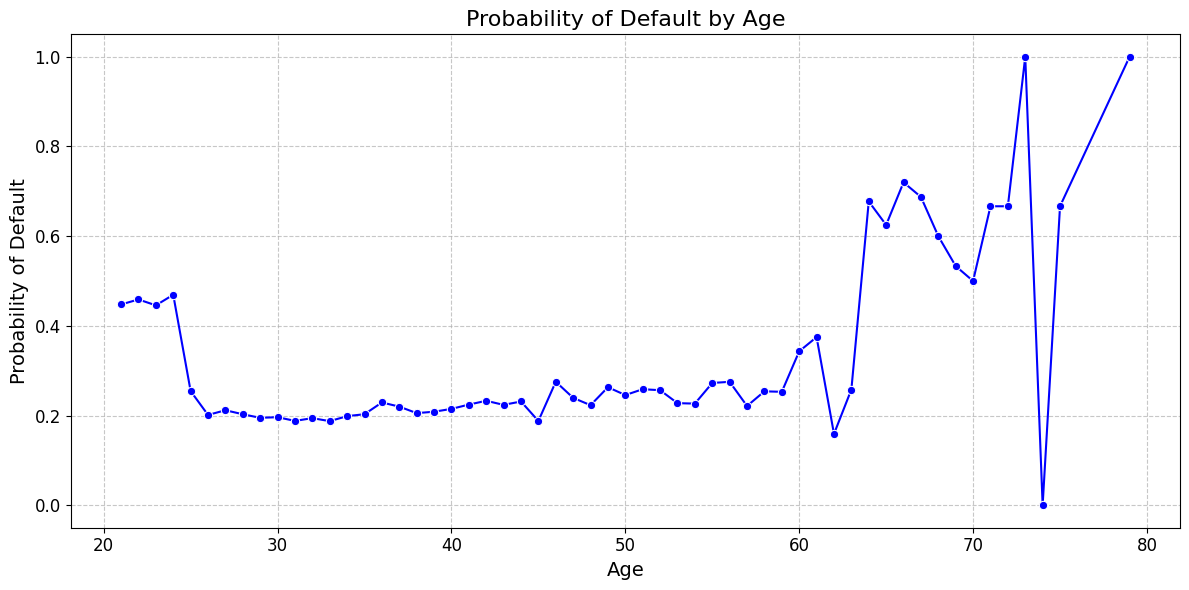

In [8]:
# mean default rate by age
age_default_prob = data.groupby("AGE")["DEFAULT_NEXT_MONTH"].mean()

# plotting the probability of default by age
plt.figure(figsize=(12, 6))
sns.lineplot(x=age_default_prob.index, y=age_default_prob.values, marker="o", linestyle="-", color="blue")
plt.title("Probability of Default by Age", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Probability of Default", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

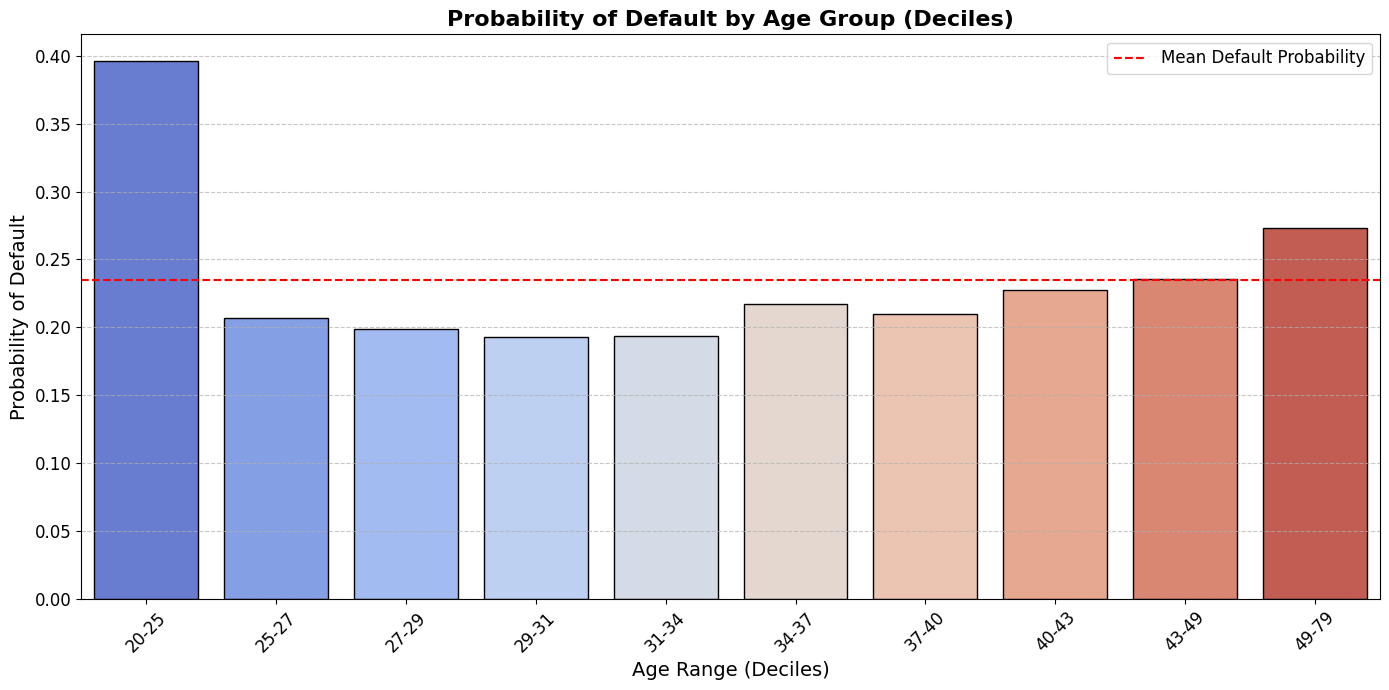

In [9]:
# bin ages into deciles
age_bins = pd.qcut(data["AGE"], q=10, duplicates="drop")
data["Age_Group"] = age_bins

# get range labels for the deciles
age_range_labels = [
    f"{int(interval.left)}-{int(interval.right)}"
    for interval in age_bins.cat.categories
]

# mapping these range labels back to the data
data["Age_Group"] = data["Age_Group"].cat.rename_categories(age_range_labels)

# calculate default probabilities for each age group
age_default_prob = (
    data.groupby("Age_Group", observed=True)["DEFAULT_NEXT_MONTH"]
    .mean()
    .reset_index()
    .rename(columns={"DEFAULT_NEXT_MONTH": "Default_Probability"})
)

# plotting default probabilities
plt.figure(figsize=(14, 7))
sns.barplot(
    data=age_default_prob,
    x="Age_Group",
    y="Default_Probability",
    palette="coolwarm",
    edgecolor="black",
)
plt.axhline(
    y=age_default_prob["Default_Probability"].mean(),
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Mean Default Probability",
)
plt.title("Probability of Default by Age Group (Deciles)", fontsize=16, fontweight="bold")
plt.xlabel("Age Range (Deciles)", fontsize=14)
plt.ylabel("Probability of Default", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

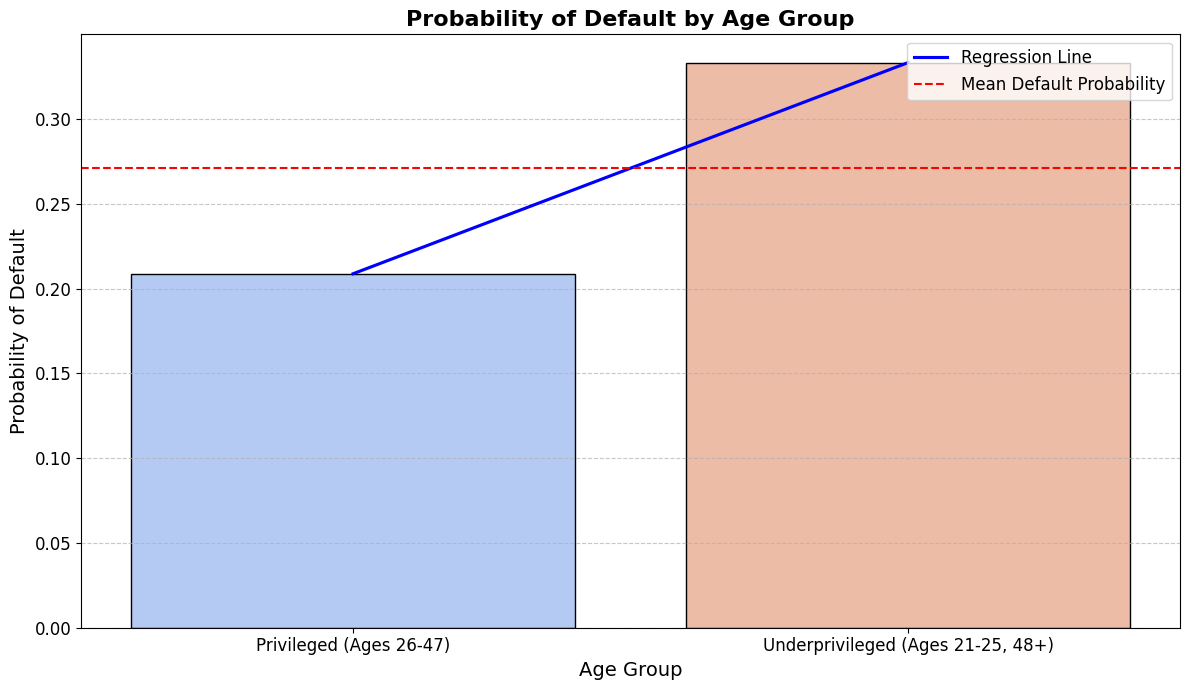

In [10]:
# define privileged (26-47) and underprivileged groups (21-25, 48+)
data["Age_Group"] = data["AGE"].apply(
    lambda x: "Privileged (Ages 26-47)" if 26 <= x <= 47 else "Underprivileged (Ages 21-25, 48+)"
)

# calculate default probabilities for each group
age_group_default_prob = (
    data.groupby("Age_Group", observed=True)["DEFAULT_NEXT_MONTH"]
    .mean()
    .reset_index()
    .rename(columns={"DEFAULT_NEXT_MONTH": "Default_Probability"})
)

# plot default probabilities with a regression line
plt.figure(figsize=(12, 7))
sns.barplot(
    data=age_group_default_prob,
    x="Age_Group",
    y="Default_Probability",
    palette="coolwarm",
    edgecolor="black"
)
sns.regplot(
    x=np.arange(len(age_group_default_prob)),
    y=age_group_default_prob["Default_Probability"],
    scatter=False, color="blue", label="Regression Line", ci=None
)
plt.axhline(
    y=age_group_default_prob["Default_Probability"].mean(),
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Mean Default Probability"
)
plt.title("Probability of Default by Age Group", fontsize=16, fontweight="bold")
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Probability of Default", fontsize=14)
plt.xticks(ticks=np.arange(len(age_group_default_prob)), labels=age_group_default_prob["Age_Group"], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

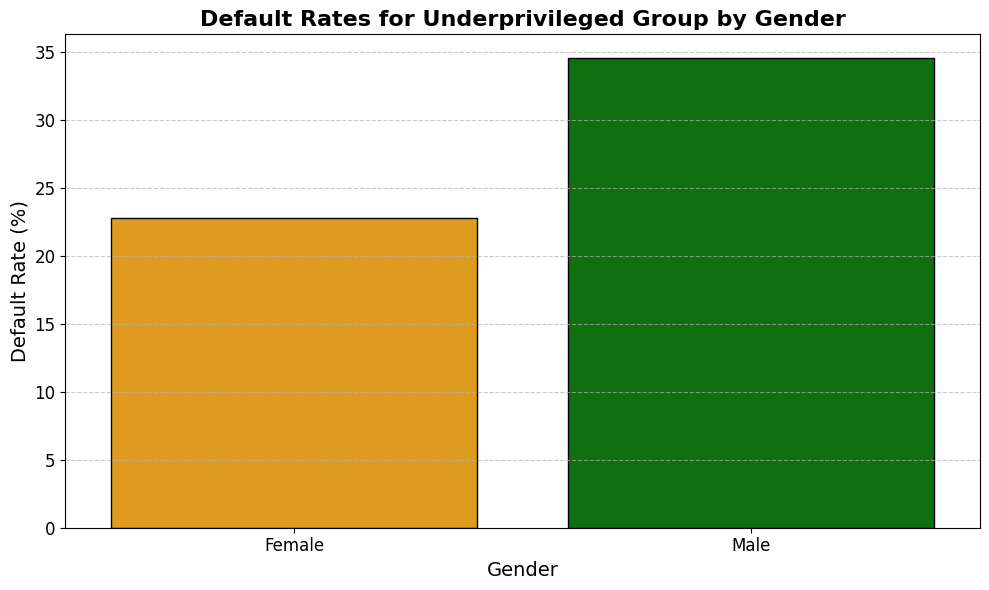

In [11]:
# define Age_Group for privileged and underprivileged groups
youngest_quartile = data["AGE"].quantile(0.25)
oldest_quartile = data["AGE"].quantile(0.75)

data["Age_Group"] = data["AGE"].apply(
    lambda x: 1 if youngest_quartile < x <= oldest_quartile else 0
)  # 1 for Privileged 0 for Underprivileged

# dbouble checking the gender encoding
data["Gender_Label"] = data["SEX"].replace({1: "Male", 0: "Female"})

# underprivileged group
underprivileged_group = data[data["Age_Group"] == 0]

# default probabilities for males and females in the underprivileged group
default_rates_underprivileged = (
    underprivileged_group.groupby("Gender_Label")["DEFAULT_NEXT_MONTH"].mean() * 100
)

# bar plot for default rates in the underprivileged group x gender
plt.figure(figsize=(10, 6))
sns.barplot(
    x=default_rates_underprivileged.index,
    y=default_rates_underprivileged.values,
    palette=["orange", "green"],
    edgecolor="black"
)
plt.title("Default Rates for Underprivileged Group by Gender", fontsize=16, fontweight="bold")
plt.ylabel("Default Rate (%)", fontsize=14)
plt.xlabel("Gender", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Quantifying Dataset Bias

In [12]:
# set seed
rand = 531
np.random.seed(rand)

# defining our target and features
y = data["DEFAULT_NEXT_MONTH"]
X = data.drop(["DEFAULT_NEXT_MONTH"], axis=1).copy()

# splitting into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand)

In [13]:
# privileged and underprivileged Groups for Age
X_train["Age_Group"] = X_train["AGE"].apply(lambda x: 1 if 26 <= x <= 47 else 0).copy()
X_test["Age_Group"] = X_test["AGE"].apply(lambda x: 1 if 26 <= x <= 47 else 0).copy()

In [14]:
# gender
X_train["Gender_Label"] = X_train["SEX"].replace({1: 1, 0: 0})  # female 0, male 1
X_test["Gender_Label"] = X_test["SEX"].replace({1: 1, 0: 0})

In [15]:
# combine X_train and y_train for BinaryLabelDataset
train_ds = BinaryLabelDataset(
    df=X_train.join(y_train),
    label_names=["DEFAULT_NEXT_MONTH"],
    protected_attribute_names=["Age_Group", "Gender_Label"],
    favorable_label=0,  # 0 did not default
    unfavorable_label=1  # 1 defaulted
)

In [16]:
# defining our groups, remember- privileged is 26-47 and underprivileged is 21-25, & 48+
privileged_groups = [{"Age_Group": 1}]
unprivileged_groups = [{"Age_Group": 0}]

In [17]:
# then, compute our metrics for training data
metrics_train_ds = BinaryLabelDatasetMetric(
    train_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# print results from training data
print("Training Data Metrics:")
print(f"Statistical Parity Difference (SPD): {metrics_train_ds.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_train_ds.disparate_impact():.4f}")
print(f"Smoothed Empirical Differential Fairness (SEDF): {metrics_train_ds.smoothed_empirical_differential_fairness():.4f}")

Training Data Metrics:
Statistical Parity Difference (SPD): -0.1202
Disparate Impact (DI): 0.8480
Smoothed Empirical Differential Fairness (SEDF): 0.8774


## Quantifying Model Bias

In [18]:
# train our LightGBM classifier
lgb_params = {
    'learning_rate': 0.4,
    'reg_alpha': 21,
    'reg_lambda': 1,
    'scale_pos_weight': 1.8
}

lgb_base_model = LGBMClassifier(random_seed=531, max_depth=6, num_leaves=33, **lgb_params)
lgb_base_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5373, number of negative: 17127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3521
[LightGBM] [Info] Number of data points in the train set: 22500, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238800 -> initscore=-1.159270
[LightGBM] [Info] Start training from score -1.159270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(learning_rate=0.4, max_depth=6, num_leaves=33, random_seed=531,
               reg_alpha=21, reg_lambda=1, scale_pos_weight=1.8)

In [19]:
# evaluate model
y_pred_test = lgb_base_model.predict(X_test)
y_pred_prob_test = lgb_base_model.predict_proba(X_test)[:, 1]

# performance metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_prob_test)

print(f"Accuracy (Test): {accuracy:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")
print(f"ROC-AUC (Test): {roc_auc:.4f}")

Accuracy (Test): 0.8176
Precision (Test): 0.6488
Recall (Test): 0.5404
F1-Score (Test): 0.5897
ROC-AUC (Test): 0.7991


<b>Training Metrics:</b>
- Accuracy (Train): 0.8406
- Precision (Train): 0.6911
- Recall (Train): 0.6013
- F1-Score (Train): 0.6431
- ROC-AUC (Train): 0.8802

<b>Test Metrics:</b>
- Accuracy (Test): 0.8176
- Precision (Test): 0.6488
- Recall (Test): 0.5404
- F1-Score (Test): 0.5897
- ROC-AUC (Test): 0.79917991.8802

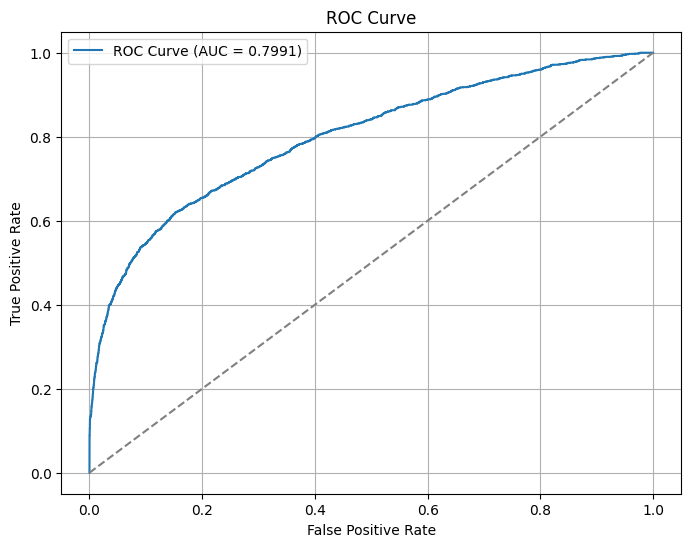

In [20]:
# there was a biggest decrease in the ROC curve, so it is worthwhile to visualize it
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# passing test_ds into BinaryLabelDataset
test_ds = BinaryLabelDataset(
    df=X_test.join(y_test),
    label_names=["DEFAULT_NEXT_MONTH"],
    protected_attribute_names=["Age_Group", "Gender_Label"],
    favorable_label=0,  # 0 no default
    unfavorable_label=1  # 1 defaulted
)
# add predictions and scores to the test dataset for our fairness metrics
test_pred_ds = test_ds.copy(deepcopy=True)
test_pred_ds.labels = y_pred_test.reshape(-1, 1)
test_pred_ds.scores = y_pred_prob_test.reshape(-1, 1)

# Compute fairness metrics
metrics_test_cls = ClassificationMetric(
    test_ds,
    test_pred_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# print fairness metrics
print("\nFairness Metrics on Test Data:")
print(f"Statistical Parity Difference (SPD): {metrics_test_cls.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_test_cls.disparate_impact():.4f}")
print(f"Smoothed Empirical Differential Fairness (SEDF): {metrics_train_ds.smoothed_empirical_differential_fairness():.4f}")


Fairness Metrics on Test Data:
Statistical Parity Difference (SPD): -0.1385
Disparate Impact (DI): 0.8339
Smoothed Empirical Differential Fairness (SEDF): 0.8774


<b>Training Data Metrics:</b>
- Statistical Parity Difference (SPD): -0.1202
- Disparate Impact (DI): 0.8480
- Smoothed Empirical Differential Fairness (SEDF): 0.8774

## Mitigating Bias

### Pre-Processing Bias Mitigation Methods

#### Reweighting (Reweighing) Method

In [22]:
# apply reweighing
reweighter = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
reweighter.fit(train_ds)
train_rw_ds = reweighter.transform(train_ds)

# metrics for the reweighted training dataset
metrics_train_rw_ds = BinaryLabelDatasetMetric(
    train_rw_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# print metrics
print('Reweighted Training Data Metrics:')
print(f'Statistical Parity Difference (SPD): {metrics_train_rw_ds.statistical_parity_difference():.4f}')
print(f'Disparate Impact (DI): {metrics_train_rw_ds.disparate_impact():.4f}')
print(f'Smoothed Empirical Differential Fairness (SEDF): {metrics_train_rw_ds.smoothed_empirical_differential_fairness():.4f}')

Reweighted Training Data Metrics:
Statistical Parity Difference (SPD): -0.0000
Disparate Impact (DI): 1.0000
Smoothed Empirical Differential Fairness (SEDF): 0.7310


### Training LightGBM on the Reweighted Dataset

In [23]:
# train LightGbM
lgb_rw_model = LGBMClassifier(
    random_state=531,
    max_depth=6,
    num_leaves=33,
    **lgb_params
)

# use reweighted dataset's instance weights
lgb_rw_model.fit(
    X_train,
    y_train,
    sample_weight=train_rw_ds.instance_weights
)



[LightGBM] [Info] Number of positive: 5373, number of negative: 17127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3521
[LightGBM] [Info] Number of data points in the train set: 22500, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238800 -> initscore=-1.159270
[LightGBM] [Info] Start training from score -1.159270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(learning_rate=0.4, max_depth=6, num_leaves=33, random_state=531,
               reg_alpha=21, reg_lambda=1, scale_pos_weight=1.8)

In [24]:
# evaluate performance metrics
y_pred_test_rw = lgb_rw_model.predict(X_test)
y_pred_prob_test_rw = lgb_rw_model.predict_proba(X_test)[:, 1]

# Compute performance metrics
accuracy_rw = accuracy_score(y_test, y_pred_test_rw)
precision_rw = precision_score(y_test, y_pred_test_rw)
recall_rw = recall_score(y_test, y_pred_test_rw)
f1_rw = f1_score(y_test, y_pred_test_rw)
roc_auc_rw = roc_auc_score(y_test, y_pred_prob_test_rw)

# display
print("\nPerformance Metrics for Reweighted Model:")
print(f"Accuracy (Test): {accuracy_rw:.4f}")
print(f"Precision (Test): {precision_rw:.4f}")
print(f"Recall (Test): {recall_rw:.4f}")
print(f"F1-Score (Test): {f1_rw:.4f}")
print(f"ROC-AUC (Test): {roc_auc_rw:.4f}")


Performance Metrics for Reweighted Model:
Accuracy (Test): 0.8057
Precision (Test): 0.6140
Recall (Test): 0.5360
F1-Score (Test): 0.5724
ROC-AUC (Test): 0.7908


In [25]:
# compute fairness metrics & add predictions/scores to test ds
test_pred_rw_ds = test_ds.copy(deepcopy=True)
test_pred_rw_ds.labels = y_pred_test_rw.reshape(-1, 1)
test_pred_rw_ds.scores = y_pred_prob_test_rw.reshape(-1, 1)

# fairness metrics for the reweighted model
metrics_test_rw_cls = ClassificationMetric(
    test_ds,
    test_pred_rw_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# print
print("\nFairness Metrics for Reweighted Model on Test Data:")
print(f"Statistical Parity Difference (SPD): {metrics_test_rw_cls.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_test_rw_cls.disparate_impact():.4f}")
print(f"Equal Opportunity Difference (EOD): {metrics_test_rw_cls.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference (AOD): {metrics_test_rw_cls.average_odds_difference():.4f}")
print(f"Differential Fairness Bias Amplification (DFBA): {metrics_test_rw_cls.differential_fairness_bias_amplification():.4f}")


Fairness Metrics for Reweighted Model on Test Data:
Statistical Parity Difference (SPD): -0.0541
Disparate Impact (DI): 0.9326
Equal Opportunity Difference (EOD): 0.0318
Average Odds Difference (AOD): -0.0133
Differential Fairness Bias Amplification (DFBA): 0.1209


In [26]:
# comparing results
print("\nComparison of Original and Reweighted Models:")
print("\nPerformance Metrics:")
print(f"Original Model Accuracy: {accuracy:.4f} | Reweighted Model Accuracy: {accuracy_rw:.4f}")
print(f"Original Model Precision: {precision:.4f} | Reweighted Model Precision: {precision_rw:.4f}")
print(f"Original Model Recall: {recall:.4f} | Reweighted Model Recall: {recall_rw:.4f}")
print(f"Original Model F1-Score: {f1:.4f} | Reweighted Model F1-Score: {f1_rw:.4f}")
print(f"Original Model ROC-AUC: {roc_auc:.4f} | Reweighted Model ROC-AUC: {roc_auc_rw:.4f}")

print("\nFairness Metrics:")
print(f"Original SPD: {metrics_test_cls.statistical_parity_difference():.4f} | Reweighted SPD: {metrics_test_rw_cls.statistical_parity_difference():.4f}")
print(f"Original DI: {metrics_test_cls.disparate_impact():.4f} | Reweighted DI: {metrics_test_rw_cls.disparate_impact():.4f}")
print(f"Original SEDF: {metrics_test_cls.smoothed_empirical_differential_fairness():.4f} | Reweighted SEDF: {metrics_train_rw_ds.smoothed_empirical_differential_fairness():.4f}")


Comparison of Original and Reweighted Models:

Performance Metrics:
Original Model Accuracy: 0.8176 | Reweighted Model Accuracy: 0.8057
Original Model Precision: 0.6488 | Reweighted Model Precision: 0.6140
Original Model Recall: 0.5404 | Reweighted Model Recall: 0.5360
Original Model F1-Score: 0.5897 | Reweighted Model F1-Score: 0.5724
Original Model ROC-AUC: 0.7991 | Reweighted Model ROC-AUC: 0.7908

Fairness Metrics:
Original SPD: -0.1385 | Reweighted SPD: -0.0541
Original DI: 0.8339 | Reweighted DI: 0.9326
Original SEDF: 0.9115 | Reweighted SEDF: 0.7310


## Disparate Impact Remover (DIR)

The main goal of the DIR is to remove or reduce the disparate impact (unfair treatment) that arises due to sensitive or protected attributes (i.e. age, gender). This is done by "repairing" the data so that the values of the sensitive attribute(s) have minimal influence on the non-sensitive attributes while maintaining the relationship with the target variable.

The repair level ranges from 0 to 1.
- Repair Level = 0: No modification to the dataset, the data remains unchanged.
- Repair Level = 1: The sensitive attribute is completely removed, and the features are "repaired" to have no correlation with the sensitive attribute.
- Intermediate Levels (i.e. 0.5) balance between preserving data utility and reducing disparate impact.

<b>Benefits:</b>Removes bias before training the model, so it can be applied before any ML model and ensures that modified features are less correlated with sensitive attributes, leading to fairer predictions.

<b>Limitations:</b>Reducing the influence of sensitive attributes might reduce the predictive performance of the model. Also, DIR requires a balance in the repair level to avoid overcorrection which could potentially remove useful information.

In [27]:
#!pip install aif360
!pip install BlackBoxAuditing
!pip install --upgrade aif360 lightgbm


In [28]:
# define the levels for repair
levels = np.hstack([np.linspace(0., 0.1, 41), np.linspace(0.2, 1, 9)])
protected_index = train_ds.feature_names.index("Age_Group")

# initialize variables to track the best repair level
di = np.array([])  # Collect Disparate Impact for all levels
train_dir_ds = None
test_dir_ds = None
X_train_dir = None
X_test_dir = None
lgb_dir_model = None

In [29]:
# loop through repair levels
for level in tqdm(levels):
    #apply DIR at the current repair level
    di_remover = DisparateImpactRemover(repair_level=level)
    train_dir_ds_i = di_remover.fit_transform(train_ds)
    test_dir_ds_i = di_remover.fit_transform(test_ds)

    #remove protected attribute from the features
    X_train_dir_i = np.delete(train_dir_ds_i.features, protected_index, axis=1)
    X_test_dir_i = np.delete(test_dir_ds_i.features, protected_index, axis=1)

    # train LightGBM model on the repaired dataset
    lgb_dir_model_i = lgb.LGBMClassifier(
        random_state=rand, max_depth=5, num_leaves=33, verbose=-1, **lgb_params
    )
    lgb_dir_model_i.fit(X_train_dir_i, train_dir_ds_i.labels)

    #predict on the repaired test dataset
    test_dir_ds_pred_i = test_dir_ds_i.copy()
    test_dir_ds_pred_i.labels = lgb_dir_model_i.predict(X_test_dir_i)

    # fairness metrics
    metrics_test_dir_ds = BinaryLabelDatasetMetric(
        test_dir_ds_pred_i,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    di_i = metrics_test_dir_ds.disparate_impact()

    # track and print DI for this level
    print(f"Repair Level: {level:.2f}, Disparate Impact: {di_i:.4f}")

    # update the best results if this level is closest to DI=1
    if (di.shape[0] == 0) or (np.min(np.abs(di - 1)) >= abs(di_i - 1)):
        train_dir_ds = train_dir_ds_i
        test_dir_ds = test_dir_ds_i
        X_train_dir = X_train_dir_i
        X_test_dir = X_test_dir_i
        lgb_dir_model = lgb_dir_model_i

    # append to DI list
    di = np.append(di, di_i)


  2%|▏         | 1/50 [00:20<16:49, 20.59s/it]

Repair Level: 0.00, Disparate Impact: 0.8350


  4%|▍         | 2/50 [00:36<14:28, 18.09s/it]

Repair Level: 0.00, Disparate Impact: 0.8464


  6%|▌         | 3/50 [00:44<10:24, 13.29s/it]

Repair Level: 0.01, Disparate Impact: 0.8401


  8%|▊         | 4/50 [00:54<09:04, 11.84s/it]

Repair Level: 0.01, Disparate Impact: 0.8405


 10%|█         | 5/50 [01:02<08:00, 10.67s/it]

Repair Level: 0.01, Disparate Impact: 0.8419


 12%|█▏        | 6/50 [01:10<07:08,  9.75s/it]

Repair Level: 0.01, Disparate Impact: 0.8330


 14%|█▍        | 7/50 [01:20<06:55,  9.66s/it]

Repair Level: 0.01, Disparate Impact: 0.8332


 16%|█▌        | 8/50 [01:27<06:19,  9.03s/it]

Repair Level: 0.02, Disparate Impact: 0.8338


 18%|█▊        | 9/50 [01:36<06:07,  8.96s/it]

Repair Level: 0.02, Disparate Impact: 0.8365


 20%|██        | 10/50 [01:45<06:00,  9.00s/it]

Repair Level: 0.02, Disparate Impact: 0.8393


 22%|██▏       | 11/50 [01:52<05:29,  8.46s/it]

Repair Level: 0.03, Disparate Impact: 0.8398


 24%|██▍       | 12/50 [02:02<05:30,  8.70s/it]

Repair Level: 0.03, Disparate Impact: 0.8317


 26%|██▌       | 13/50 [02:10<05:17,  8.59s/it]

Repair Level: 0.03, Disparate Impact: 0.8422


 28%|██▊       | 14/50 [02:18<05:01,  8.37s/it]

Repair Level: 0.03, Disparate Impact: 0.8403


 30%|███       | 15/50 [02:27<04:59,  8.57s/it]

Repair Level: 0.04, Disparate Impact: 0.8363


 32%|███▏      | 16/50 [02:34<04:40,  8.25s/it]

Repair Level: 0.04, Disparate Impact: 0.8439


 34%|███▍      | 17/50 [02:43<04:38,  8.43s/it]

Repair Level: 0.04, Disparate Impact: 0.8417


 36%|███▌      | 18/50 [02:52<04:36,  8.65s/it]

Repair Level: 0.04, Disparate Impact: 0.8447


 38%|███▊      | 19/50 [03:00<04:20,  8.39s/it]

Repair Level: 0.04, Disparate Impact: 0.8406


 40%|████      | 20/50 [03:09<04:16,  8.55s/it]

Repair Level: 0.05, Disparate Impact: 0.8439


 42%|████▏     | 21/50 [03:17<04:03,  8.41s/it]

Repair Level: 0.05, Disparate Impact: 0.8377


 44%|████▍     | 22/50 [03:26<03:54,  8.38s/it]

Repair Level: 0.05, Disparate Impact: 0.8327


 46%|████▌     | 23/50 [03:34<03:50,  8.53s/it]

Repair Level: 0.06, Disparate Impact: 0.8407


 48%|████▊     | 24/50 [03:42<03:34,  8.24s/it]

Repair Level: 0.06, Disparate Impact: 0.8362


 50%|█████     | 25/50 [03:51<03:30,  8.43s/it]

Repair Level: 0.06, Disparate Impact: 0.8369


 52%|█████▏    | 26/50 [03:59<03:21,  8.41s/it]

Repair Level: 0.06, Disparate Impact: 0.8259


 54%|█████▍    | 27/50 [04:07<03:08,  8.19s/it]

Repair Level: 0.07, Disparate Impact: 0.8339


 56%|█████▌    | 28/50 [04:16<03:07,  8.52s/it]

Repair Level: 0.07, Disparate Impact: 0.8403


 58%|█████▊    | 29/50 [04:24<02:55,  8.35s/it]

Repair Level: 0.07, Disparate Impact: 0.8337


 60%|██████    | 30/50 [04:32<02:46,  8.34s/it]

Repair Level: 0.07, Disparate Impact: 0.8325


 62%|██████▏   | 31/50 [04:42<02:42,  8.56s/it]

Repair Level: 0.07, Disparate Impact: 0.8327


 64%|██████▍   | 32/50 [04:49<02:27,  8.18s/it]

Repair Level: 0.08, Disparate Impact: 0.8477


 66%|██████▌   | 33/50 [04:58<02:22,  8.40s/it]

Repair Level: 0.08, Disparate Impact: 0.8339


 68%|██████▊   | 34/50 [05:07<02:17,  8.61s/it]

Repair Level: 0.08, Disparate Impact: 0.8285


 70%|███████   | 35/50 [05:15<02:05,  8.38s/it]

Repair Level: 0.09, Disparate Impact: 0.8313


 72%|███████▏  | 36/50 [05:24<02:01,  8.70s/it]

Repair Level: 0.09, Disparate Impact: 0.8284


 74%|███████▍  | 37/50 [05:33<01:51,  8.60s/it]

Repair Level: 0.09, Disparate Impact: 0.8402


 76%|███████▌  | 38/50 [05:41<01:40,  8.42s/it]

Repair Level: 0.09, Disparate Impact: 0.8428


 78%|███████▊  | 39/50 [05:50<01:34,  8.63s/it]

Repair Level: 0.10, Disparate Impact: 0.8385


 80%|████████  | 40/50 [05:58<01:24,  8.40s/it]

Repair Level: 0.10, Disparate Impact: 0.8421


 82%|████████▏ | 41/50 [06:06<01:16,  8.54s/it]

Repair Level: 0.10, Disparate Impact: 0.8421


 84%|████████▍ | 42/50 [06:16<01:10,  8.78s/it]

Repair Level: 0.20, Disparate Impact: 0.8495


 86%|████████▌ | 43/50 [06:23<00:59,  8.48s/it]

Repair Level: 0.30, Disparate Impact: 0.8617


 88%|████████▊ | 44/50 [06:32<00:51,  8.52s/it]

Repair Level: 0.40, Disparate Impact: 0.8683


 90%|█████████ | 45/50 [06:40<00:42,  8.42s/it]

Repair Level: 0.50, Disparate Impact: 0.8667


 92%|█████████▏| 46/50 [06:48<00:32,  8.15s/it]

Repair Level: 0.60, Disparate Impact: 0.7952


 94%|█████████▍| 47/50 [06:56<00:24,  8.26s/it]

Repair Level: 0.70, Disparate Impact: 0.8285


 96%|█████████▌| 48/50 [07:03<00:15,  7.86s/it]

Repair Level: 0.80, Disparate Impact: 0.8349


 98%|█████████▊| 49/50 [07:11<00:07,  7.97s/it]

Repair Level: 0.90, Disparate Impact: 0.8117


100%|██████████| 50/50 [07:17<00:00,  8.76s/it]

Repair Level: 1.00, Disparate Impact: 0.8123


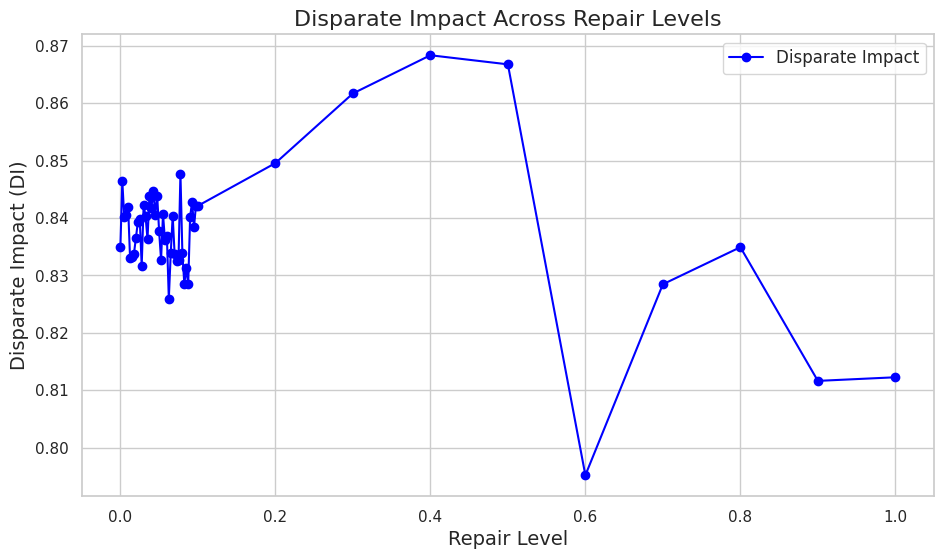

In [30]:
# Plot Disparate Impact across repair levels
import matplotlib.pyplot as plt
import seaborn as sns

di = di[:len(levels)]

# Use Seaborn style for better visuals
sns.set(style="whitegrid")

plt.figure(figsize=(11, 6))

# Plot the Disparate Impact (DI) against repair levels
plt.plot(levels, di, marker="o", linestyle="-", color="blue", label="Disparate Impact")

# Add labels, title, and legend
plt.ylabel("Disparate Impact (DI)", fontsize=14)
plt.xlabel("Repair Level", fontsize=14)
plt.title("Disparate Impact Across Repair Levels", fontsize=16)
plt.legend(fontsize=12)

# Show grid for readability
plt.grid(True)

# Display the plot
plt.show()

from IPython.display import display
display(plt.gcf())


In [31]:
# print the best repair level and its corresponding disparate impact
best_level = levels[np.argmin(np.abs(di - 1))]
print(f"Best Repair Level: {best_level:.2f}")
print(f"Disparate Impact at Best Level: {di[np.argmin(np.abs(di - 1))]:.4f}")


Best Repair Level: 0.40
Disparate Impact at Best Level: 0.8683


In [32]:
# predict on the modified test data (from DIR)
y_pred_test_dir = lgb_dir_model.predict(X_test_dir)
y_pred_prob_test_dir = lgb_dir_model.predict_proba(X_test_dir)[:, 1]

# compute performance metrics on the test data
accuracy_test_dir = accuracy_score(y_test, y_pred_test_dir)
precision_test_dir = precision_score(y_test, y_pred_test_dir)
recall_test_dir = recall_score(y_test, y_pred_test_dir)
f1_test_dir = f1_score(y_test, y_pred_test_dir)
roc_auc_test_dir = roc_auc_score(y_test, y_pred_prob_test_dir)

#display
print("Performance Metrics on Test Data (DIR Applied):")
print(f"Accuracy: {accuracy_test_dir:.4f}")
print(f"Precision: {precision_test_dir:.4f}")
print(f"Recall: {recall_test_dir:.4f}")
print(f"F1-Score: {f1_test_dir:.4f}")
print(f"ROC-AUC: {roc_auc_test_dir:.4f}")

# predictions and scores to the BinaryLabelDataset for our fairness metrics
test_dir_ds_pred = test_dir_ds.copy(deepcopy=True)
test_dir_ds_pred.labels = y_pred_test_dir.reshape(-1, 1)
test_dir_ds_pred.scores = y_pred_prob_test_dir.reshape(-1, 1)

# fairness metrics
metrics_test_dir_cls = ClassificationMetric(
    test_dir_ds,
    test_dir_ds_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# display
print("\nFairness Metrics on Test Data (DIR Applied):")
print(f"Statistical Parity Difference (SPD): {metrics_test_dir_cls.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_test_dir_cls.disparate_impact():.4f}")
print(f"Equal Opportunity Difference (EOD): {metrics_test_dir_cls.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference (AOD): {metrics_test_dir_cls.average_odds_difference():.4f}")
print(f"Differential Fairness Bias Amplification (DFBA): {metrics_test_dir_cls.differential_fairness_bias_amplification():.4f}")


Performance Metrics on Test Data (DIR Applied):
Accuracy: 0.8109
Precision: 0.6281
Recall: 0.5404
F1-Score: 0.5810
ROC-AUC: 0.7949

Fairness Metrics on Test Data (DIR Applied):
Statistical Parity Difference (SPD): -0.1078
Disparate Impact (DI): 0.8683
Equal Opportunity Difference (EOD): -0.0170
Average Odds Difference (AOD): -0.0699
Differential Fairness Bias Amplification (DFBA): 0.1588


In [33]:
# Comparison of ALL Performance Metrics
print("\nComparison of Performance Metrics Across Models:")
print(f"{'Metric':<15}{'Original':<15}{'Reweighted':<15}{'DIR Applied':<15}")
print("-" * 60)
print(f"{'Accuracy':<15}{accuracy:<15.4f}{accuracy_rw:<15.4f}{accuracy_test_dir:<15.4f}")
print(f"{'Precision':<15}{precision:<15.4f}{precision_rw:<15.4f}{precision_test_dir:<15.4f}")
print(f"{'Recall':<15}{recall:<15.4f}{recall_rw:<15.4f}{recall_test_dir:<15.4f}")
print(f"{'F1-Score':<15}{f1:<15.4f}{f1_rw:<15.4f}{f1_test_dir:<15.4f}")
print(f"{'ROC-AUC':<15}{roc_auc:<15.4f}{roc_auc_rw:<15.4f}{roc_auc_test_dir:<15.4f}")

# Comparison of ALL Fairness Metrics (SPD, DI, SEDF)
print("\nComparison of Fairness Metrics Across Models:")
print(f"{'Metric':<15}{'Original':<15}{'Reweighted':<15}{'DIR Applied':<15}")
print("-" * 60)
print(f"{'SPD':<15}{metrics_test_cls.statistical_parity_difference():<15.4f}{metrics_test_rw_cls.statistical_parity_difference():<15.4f}{metrics_test_dir_cls.statistical_parity_difference():<15.4f}")
print(f"{'DI':<15}{metrics_test_cls.disparate_impact():<15.4f}{metrics_test_rw_cls.disparate_impact():<15.4f}{metrics_test_dir_cls.disparate_impact():<15.4f}")
print(f"{'SEDF':<15}{metrics_test_cls.smoothed_empirical_differential_fairness():<15.4f}{metrics_train_rw_ds.smoothed_empirical_differential_fairness():<15.4f}{metrics_test_dir_cls.smoothed_empirical_differential_fairness():<15.4f}")


Comparison of Performance Metrics Across Models:
Metric         Original       Reweighted     DIR Applied    
------------------------------------------------------------
Accuracy       0.8176         0.8057         0.8109         
Precision      0.6488         0.6140         0.6281         
Recall         0.5404         0.5360         0.5404         
F1-Score       0.5897         0.5724         0.5810         
ROC-AUC        0.7991         0.7908         0.7949         

Comparison of Fairness Metrics Across Models:
Metric         Original       Reweighted     DIR Applied    
------------------------------------------------------------
SPD            -0.1385        -0.0541        -0.1078        
DI             0.8339         0.9326         0.8683         
SEDF           0.9115         0.7310         0.9115         


*****

# Assignment Instructions

<b>Objective:</b>

In this assignment, you will explore the impact of fairness metrics after applying the Disparate Impact Remover (DIR), retrain a Light GBM model with the adjusted data, and compare its metrics (listed below) against the original and reweighted models from the lab tutorial. Afterward, respond to the reflection questions.

<b>Part 1: Experimentation with the DIR (assignment output should be included in 3.1 Exercise Document</b>

-	(Part 1.1a. & 1.1b.): Modify the levels array for the Disparate Impact Remover to include finer and coarser granularity. (See example in lab/assignment notebook.)
-	(Part 1.2): Identify the best repair level and the Disparate Impact at the best repair level.
-	(Part 1.3): Retrain a Light GBM model on the modified DIR data with the best repair level and compute both the performance metrics and the fairness metrics.


In [34]:
from tqdm import tqdm
from aif360.algorithms.preprocessing import DisparateImpactRemover
import lightgbm as lgb
from aif360.metrics import BinaryLabelDatasetMetric
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Define levels with finer & coarser granularity
levels = np.hstack([np.linspace(0., 0.1, 81), np.linspace(0.2, 1, 20)])


# Generate the levels
granular_levels = np.linspace(0., 0.1, 81)  # Fine granularity (small steps)
coarse_levels = np.linspace(0.2, 1, 20)     # Coarse granularity (larger steps)

# Combine both if needed
levels = np.hstack([granular_levels, coarse_levels])

# Print to verify
print("Granular Levels:", granular_levels)
print("\nCoarse Levels:", coarse_levels)

# Initialize variables
di = np.array([])  # Store Disparate Impact values
best_level = None
protected_index = train_ds.feature_names.index("Age_Group")

LGBMClassifier(force_row_wise=True)

for level in tqdm(levels):
    # Apply Disparate Impact Remover (DIR) at the current repair level
    di_remover = DisparateImpactRemover(repair_level=level)


    train_dir_ds_i = di_remover.fit_transform(train_ds)
    test_dir_ds_i = di_remover.fit_transform(test_ds)

    # Remove the protected attribute (Age_Group)
    X_train_dir_i = np.delete(train_dir_ds_i.features, protected_index, axis=1)
    X_test_dir_i = np.delete(test_dir_ds_i.features, protected_index, axis=1)

    # Train LightGBM model on the repaired dataset
    #lgb_dir_model_i = lgb.LGBMClassifier(random_state=531, max_depth=5, num_leaves=33)
    #lgb_dir_model_i=LGBMClassifier(random_state=10, max_depth=3,force_row_wise=True, num_leaves=33)
    #lgb_model = lgb.LGBMClassifier(
    #max_depth=6,                 # Adjust depth
    #min_data_in_leaf=50,         # Ensure minimum samples per leaf
    #feature_fraction=0.8,        # Use 80% of features per iteration
    #force_row_wise=True          # Reduce processing overhead
    #)

    # train LightGBM model on the repaired dataset
    lgb_dir_model_i = lgb.LGBMClassifier(
        random_state=rand, max_depth=5, num_leaves=33,force_row_wise=True, verbose=-1, **lgb_params
    )
    lgb_dir_model_i.fit(X_train_dir_i, train_dir_ds_i.labels)

    # Predict on the repaired test dataset
    test_dir_ds_pred_i = test_dir_ds_i.copy()
    test_dir_ds_pred_i.labels = lgb_dir_model_i.predict(X_test_dir_i)

    # Compute fairness metrics
    metrics_test_dir_ds = BinaryLabelDatasetMetric(
        test_dir_ds_pred_i,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    di_i = metrics_test_dir_ds.disparate_impact()

    # Track DI for this level
    print(f"Repair Level: {level:.4f}, Disparate Impact: {di_i:.4f}")
    di = np.append(di, di_i)




Granular Levels: [0.      0.00125 0.0025  0.00375 0.005   0.00625 0.0075  0.00875 0.01
 0.01125 0.0125  0.01375 0.015   0.01625 0.0175  0.01875 0.02    0.02125
 0.0225  0.02375 0.025   0.02625 0.0275  0.02875 0.03    0.03125 0.0325
 0.03375 0.035   0.03625 0.0375  0.03875 0.04    0.04125 0.0425  0.04375
 0.045   0.04625 0.0475  0.04875 0.05    0.05125 0.0525  0.05375 0.055
 0.05625 0.0575  0.05875 0.06    0.06125 0.0625  0.06375 0.065   0.06625
 0.0675  0.06875 0.07    0.07125 0.0725  0.07375 0.075   0.07625 0.0775
 0.07875 0.08    0.08125 0.0825  0.08375 0.085   0.08625 0.0875  0.08875
 0.09    0.09125 0.0925  0.09375 0.095   0.09625 0.0975  0.09875 0.1    ]

Coarse Levels: [0.2        0.24210526 0.28421053 0.32631579 0.36842105 0.41052632
 0.45263158 0.49473684 0.53684211 0.57894737 0.62105263 0.66315789
 0.70526316 0.74736842 0.78947368 0.83157895 0.87368421 0.91578947
 0.95789474 1.        ]


  1%|          | 1/101 [00:21<36:16, 21.77s/it]

Repair Level: 0.0000, Disparate Impact: 0.8350


  2%|▏         | 2/101 [00:37<30:01, 18.20s/it]

Repair Level: 0.0013, Disparate Impact: 0.8434


  3%|▎         | 3/101 [00:45<21:59, 13.47s/it]

Repair Level: 0.0025, Disparate Impact: 0.8464


  4%|▍         | 4/101 [00:54<18:46, 11.61s/it]

Repair Level: 0.0037, Disparate Impact: 0.8467


  5%|▍         | 5/101 [01:02<16:49, 10.51s/it]

Repair Level: 0.0050, Disparate Impact: 0.8401


  6%|▌         | 6/101 [01:10<15:05,  9.53s/it]

Repair Level: 0.0063, Disparate Impact: 0.8448


  7%|▋         | 7/101 [01:19<14:47,  9.44s/it]

Repair Level: 0.0075, Disparate Impact: 0.8405


  8%|▊         | 8/101 [01:28<14:09,  9.14s/it]

Repair Level: 0.0088, Disparate Impact: 0.8367


  9%|▉         | 9/101 [01:36<13:32,  8.83s/it]

Repair Level: 0.0100, Disparate Impact: 0.8419


 10%|▉         | 10/101 [01:44<13:20,  8.80s/it]

Repair Level: 0.0112, Disparate Impact: 0.8456


 11%|█         | 11/101 [01:52<12:38,  8.42s/it]

Repair Level: 0.0125, Disparate Impact: 0.8330


 12%|█▏        | 12/101 [02:01<12:43,  8.58s/it]

Repair Level: 0.0138, Disparate Impact: 0.8420


 13%|█▎        | 13/101 [02:10<12:49,  8.75s/it]

Repair Level: 0.0150, Disparate Impact: 0.8332


 14%|█▍        | 14/101 [02:18<12:12,  8.42s/it]

Repair Level: 0.0163, Disparate Impact: 0.8411


 15%|█▍        | 15/101 [02:26<12:13,  8.53s/it]

Repair Level: 0.0175, Disparate Impact: 0.8338


 16%|█▌        | 16/101 [02:35<11:55,  8.41s/it]

Repair Level: 0.0187, Disparate Impact: 0.8443


 17%|█▋        | 17/101 [02:43<11:43,  8.37s/it]

Repair Level: 0.0200, Disparate Impact: 0.8365


 18%|█▊        | 18/101 [02:52<11:56,  8.63s/it]

Repair Level: 0.0213, Disparate Impact: 0.8367


 19%|█▉        | 19/101 [03:00<11:23,  8.34s/it]

Repair Level: 0.0225, Disparate Impact: 0.8393


 20%|█▉        | 20/101 [03:08<11:22,  8.43s/it]

Repair Level: 0.0238, Disparate Impact: 0.8381


 21%|██        | 21/101 [03:17<11:25,  8.57s/it]

Repair Level: 0.0250, Disparate Impact: 0.8398


 22%|██▏       | 22/101 [03:25<10:58,  8.34s/it]

Repair Level: 0.0262, Disparate Impact: 0.8440


 23%|██▎       | 23/101 [03:34<11:11,  8.61s/it]

Repair Level: 0.0275, Disparate Impact: 0.8317


 24%|██▍       | 24/101 [03:43<10:53,  8.49s/it]

Repair Level: 0.0288, Disparate Impact: 0.8336


 25%|██▍       | 25/101 [03:50<10:27,  8.26s/it]

Repair Level: 0.0300, Disparate Impact: 0.8422


 26%|██▌       | 26/101 [03:59<10:35,  8.47s/it]

Repair Level: 0.0312, Disparate Impact: 0.8390


 27%|██▋       | 27/101 [04:07<10:11,  8.26s/it]

Repair Level: 0.0325, Disparate Impact: 0.8403


 28%|██▊       | 28/101 [04:16<10:16,  8.44s/it]

Repair Level: 0.0338, Disparate Impact: 0.8367


 29%|██▊       | 29/101 [04:25<10:20,  8.62s/it]

Repair Level: 0.0350, Disparate Impact: 0.8363


 30%|██▉       | 30/101 [04:32<09:43,  8.21s/it]

Repair Level: 0.0362, Disparate Impact: 0.8459


 31%|███       | 31/101 [04:41<09:56,  8.53s/it]

Repair Level: 0.0375, Disparate Impact: 0.8439


 32%|███▏      | 32/101 [04:50<09:39,  8.40s/it]

Repair Level: 0.0387, Disparate Impact: 0.8439


 33%|███▎      | 33/101 [04:58<09:30,  8.39s/it]

Repair Level: 0.0400, Disparate Impact: 0.8417


 34%|███▎      | 34/101 [05:07<09:42,  8.70s/it]

Repair Level: 0.0413, Disparate Impact: 0.8429


 35%|███▍      | 35/101 [05:15<09:08,  8.30s/it]

Repair Level: 0.0425, Disparate Impact: 0.8447


 36%|███▌      | 36/101 [05:24<09:09,  8.45s/it]

Repair Level: 0.0438, Disparate Impact: 0.8400


 37%|███▋      | 37/101 [05:33<09:12,  8.63s/it]

Repair Level: 0.0450, Disparate Impact: 0.8406


 38%|███▊      | 38/101 [05:40<08:45,  8.34s/it]

Repair Level: 0.0462, Disparate Impact: 0.8307


 39%|███▊      | 39/101 [05:49<08:52,  8.58s/it]

Repair Level: 0.0475, Disparate Impact: 0.8439


 40%|███▉      | 40/101 [05:57<08:31,  8.39s/it]

Repair Level: 0.0488, Disparate Impact: 0.8368


 41%|████      | 41/101 [06:06<08:22,  8.38s/it]

Repair Level: 0.0500, Disparate Impact: 0.8377


 42%|████▏     | 42/101 [06:15<08:33,  8.69s/it]

Repair Level: 0.0513, Disparate Impact: 0.8338


 43%|████▎     | 43/101 [06:23<08:13,  8.52s/it]

Repair Level: 0.0525, Disparate Impact: 0.8327


 44%|████▎     | 44/101 [06:32<08:07,  8.54s/it]

Repair Level: 0.0537, Disparate Impact: 0.8366


 45%|████▍     | 45/101 [06:40<07:59,  8.57s/it]

Repair Level: 0.0550, Disparate Impact: 0.8407


 46%|████▌     | 46/101 [06:48<07:37,  8.32s/it]

Repair Level: 0.0563, Disparate Impact: 0.8358


 47%|████▋     | 47/101 [06:57<07:42,  8.56s/it]

Repair Level: 0.0575, Disparate Impact: 0.8362


 48%|████▊     | 48/101 [07:06<07:37,  8.63s/it]

Repair Level: 0.0588, Disparate Impact: 0.8370


 49%|████▊     | 49/101 [07:14<07:17,  8.41s/it]

Repair Level: 0.0600, Disparate Impact: 0.8369


 50%|████▉     | 50/101 [07:23<07:15,  8.55s/it]

Repair Level: 0.0612, Disparate Impact: 0.8404


 50%|█████     | 51/101 [07:30<06:51,  8.23s/it]

Repair Level: 0.0625, Disparate Impact: 0.8259


 51%|█████▏    | 52/101 [07:39<06:52,  8.41s/it]

Repair Level: 0.0638, Disparate Impact: 0.8374


 52%|█████▏    | 53/101 [07:48<06:54,  8.64s/it]

Repair Level: 0.0650, Disparate Impact: 0.8339


 53%|█████▎    | 54/101 [07:56<06:37,  8.46s/it]

Repair Level: 0.0663, Disparate Impact: 0.8376


 54%|█████▍    | 55/101 [08:05<06:31,  8.51s/it]

Repair Level: 0.0675, Disparate Impact: 0.8403


 55%|█████▌    | 56/101 [08:14<06:31,  8.71s/it]

Repair Level: 0.0688, Disparate Impact: 0.8370


 56%|█████▋    | 57/101 [08:22<06:13,  8.48s/it]

Repair Level: 0.0700, Disparate Impact: 0.8337


 57%|█████▋    | 58/101 [08:32<06:16,  8.76s/it]

Repair Level: 0.0713, Disparate Impact: 0.8298


 58%|█████▊    | 59/101 [08:40<06:04,  8.68s/it]

Repair Level: 0.0725, Disparate Impact: 0.8325


 59%|█████▉    | 60/101 [08:48<05:43,  8.37s/it]

Repair Level: 0.0737, Disparate Impact: 0.8372


 60%|██████    | 61/101 [08:57<05:42,  8.56s/it]

Repair Level: 0.0750, Disparate Impact: 0.8327


 61%|██████▏   | 62/101 [09:04<05:24,  8.31s/it]

Repair Level: 0.0762, Disparate Impact: 0.8372


 62%|██████▏   | 63/101 [09:13<05:20,  8.45s/it]

Repair Level: 0.0775, Disparate Impact: 0.8477


 63%|██████▎   | 64/101 [09:22<05:19,  8.64s/it]

Repair Level: 0.0788, Disparate Impact: 0.8378


 64%|██████▍   | 65/101 [09:30<04:57,  8.26s/it]

Repair Level: 0.0800, Disparate Impact: 0.8339


 65%|██████▌   | 66/101 [09:39<05:04,  8.70s/it]

Repair Level: 0.0813, Disparate Impact: 0.8383


 66%|██████▋   | 67/101 [09:49<05:05,  8.98s/it]

Repair Level: 0.0825, Disparate Impact: 0.8285


 67%|██████▋   | 68/101 [09:57<04:47,  8.71s/it]

Repair Level: 0.0838, Disparate Impact: 0.8376


 68%|██████▊   | 69/101 [10:07<04:48,  9.02s/it]

Repair Level: 0.0850, Disparate Impact: 0.8313


 69%|██████▉   | 70/101 [10:15<04:32,  8.78s/it]

Repair Level: 0.0863, Disparate Impact: 0.8313


 70%|███████   | 71/101 [10:23<04:15,  8.53s/it]

Repair Level: 0.0875, Disparate Impact: 0.8284


 71%|███████▏  | 72/101 [10:32<04:13,  8.74s/it]

Repair Level: 0.0887, Disparate Impact: 0.8357


 72%|███████▏  | 73/101 [10:40<03:55,  8.42s/it]

Repair Level: 0.0900, Disparate Impact: 0.8402


 73%|███████▎  | 74/101 [10:49<03:49,  8.49s/it]

Repair Level: 0.0912, Disparate Impact: 0.8389


 74%|███████▍  | 75/101 [10:57<03:40,  8.48s/it]

Repair Level: 0.0925, Disparate Impact: 0.8428


 75%|███████▌  | 76/101 [11:05<03:24,  8.19s/it]

Repair Level: 0.0938, Disparate Impact: 0.8341


 76%|███████▌  | 77/101 [11:14<03:25,  8.54s/it]

Repair Level: 0.0950, Disparate Impact: 0.8385


 77%|███████▋  | 78/101 [11:23<03:18,  8.61s/it]

Repair Level: 0.0963, Disparate Impact: 0.8407


 78%|███████▊  | 79/101 [11:31<03:06,  8.47s/it]

Repair Level: 0.0975, Disparate Impact: 0.8421


 79%|███████▉  | 80/101 [11:40<03:01,  8.62s/it]

Repair Level: 0.0988, Disparate Impact: 0.8347


 80%|████████  | 81/101 [11:48<02:47,  8.36s/it]

Repair Level: 0.1000, Disparate Impact: 0.8421


 81%|████████  | 82/101 [11:57<02:42,  8.57s/it]

Repair Level: 0.2000, Disparate Impact: 0.8495


 82%|████████▏ | 83/101 [12:06<02:37,  8.75s/it]

Repair Level: 0.2421, Disparate Impact: 0.8494


 83%|████████▎ | 84/101 [12:13<02:23,  8.44s/it]

Repair Level: 0.2842, Disparate Impact: 0.8433


 84%|████████▍ | 85/101 [12:22<02:15,  8.44s/it]

Repair Level: 0.3263, Disparate Impact: 0.8539


 85%|████████▌ | 86/101 [12:30<02:06,  8.44s/it]

Repair Level: 0.3684, Disparate Impact: 0.8566


 86%|████████▌ | 87/101 [12:38<01:55,  8.28s/it]

Repair Level: 0.4105, Disparate Impact: 0.8597


 87%|████████▋ | 88/101 [12:47<01:51,  8.56s/it]

Repair Level: 0.4526, Disparate Impact: 0.8605


 88%|████████▊ | 89/101 [12:55<01:39,  8.32s/it]

Repair Level: 0.4947, Disparate Impact: 0.8659


 89%|████████▉ | 90/101 [13:03<01:31,  8.28s/it]

Repair Level: 0.5368, Disparate Impact: 0.7930


 90%|█████████ | 91/101 [13:12<01:24,  8.49s/it]

Repair Level: 0.5789, Disparate Impact: 0.7894


 91%|█████████ | 92/101 [13:20<01:13,  8.12s/it]

Repair Level: 0.6211, Disparate Impact: 0.7959


 92%|█████████▏| 93/101 [13:29<01:07,  8.47s/it]

Repair Level: 0.6632, Disparate Impact: 0.8057


 93%|█████████▎| 94/101 [13:37<00:57,  8.28s/it]

Repair Level: 0.7053, Disparate Impact: 0.8161


 94%|█████████▍| 95/101 [13:44<00:48,  8.02s/it]

Repair Level: 0.7474, Disparate Impact: 0.8368


 95%|█████████▌| 96/101 [13:52<00:39,  7.96s/it]

Repair Level: 0.7895, Disparate Impact: 0.8335


 96%|█████████▌| 97/101 [13:59<00:30,  7.74s/it]

Repair Level: 0.8316, Disparate Impact: 0.8341


 97%|█████████▋| 98/101 [14:07<00:23,  7.86s/it]

Repair Level: 0.8737, Disparate Impact: 0.8257


 98%|█████████▊| 99/101 [14:14<00:15,  7.51s/it]

Repair Level: 0.9158, Disparate Impact: 0.8142


 99%|█████████▉| 100/101 [14:22<00:07,  7.51s/it]

Repair Level: 0.9579, Disparate Impact: 0.8074


100%|██████████| 101/101 [14:28<00:00,  8.60s/it]

Repair Level: 1.0000, Disparate Impact: 0.8123


In [35]:
di_i = di

for level, di_value in tqdm(zip(levels, di)):  # Iterate through levels and corresponding DI values
    print(f"Repair Level: {level:.4f}, Disparate Impact: {di_value:.4f}")

# Find best repair level (DI closest to 1.0)
best_level = levels[np.argmin(np.abs(di - 1))]
print(f"\nBest Repair Level: {best_level:.4f}")
print(f"Disparate Impact at Best Level: {di[np.argmin(np.abs(di - 1))]:.4f}")

101it [00:00, 132258.73it/s]

Repair Level: 0.0000, Disparate Impact: 0.8350
Repair Level: 0.0013, Disparate Impact: 0.8434
Repair Level: 0.0025, Disparate Impact: 0.8464
Repair Level: 0.0037, Disparate Impact: 0.8467
Repair Level: 0.0050, Disparate Impact: 0.8401
Repair Level: 0.0063, Disparate Impact: 0.8448
Repair Level: 0.0075, Disparate Impact: 0.8405
Repair Level: 0.0088, Disparate Impact: 0.8367
Repair Level: 0.0100, Disparate Impact: 0.8419
Repair Level: 0.0112, Disparate Impact: 0.8456
Repair Level: 0.0125, Disparate Impact: 0.8330
Repair Level: 0.0138, Disparate Impact: 0.8420
Repair Level: 0.0150, Disparate Impact: 0.8332
Repair Level: 0.0163, Disparate Impact: 0.8411
Repair Level: 0.0175, Disparate Impact: 0.8338
Repair Level: 0.0187, Disparate Impact: 0.8443
Repair Level: 0.0200, Disparate Impact: 0.8365
Repair Level: 0.0213, Disparate Impact: 0.8367
Repair Level: 0.0225, Disparate Impact: 0.8393
Repair Level: 0.0238, Disparate Impact: 0.8381
Repair Level: 0.0250, Disparate Impact: 0.8398
Repair Level:

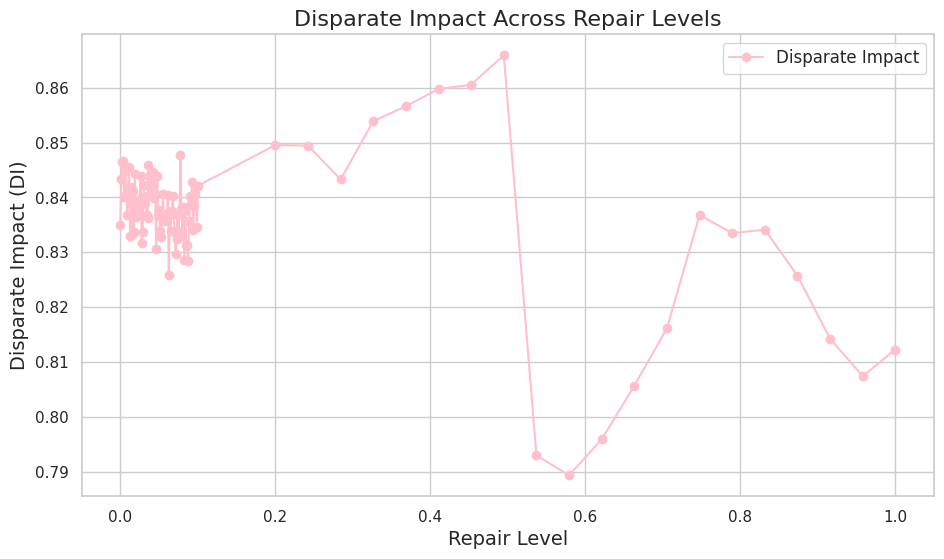

In [36]:
# Plot Disparate Impact across repair levels
import matplotlib.pyplot as plt
import seaborn as sns

di_i = di_i[:len(levels)]
#di = di[:len(levels)]

# Use Seaborn style for better visuals
sns.set(style="whitegrid")

plt.figure(figsize=(11, 6))

# Plot the Disparate Impact (DI) against repair levels
plt.plot(levels, di_i, marker="o", linestyle="-", color="pink", label="Disparate Impact")

# Add labels, title, and legend
plt.ylabel("Disparate Impact (DI)", fontsize=14)
plt.xlabel("Repair Level", fontsize=14)
plt.title("Disparate Impact Across Repair Levels", fontsize=16)
plt.legend(fontsize=12)

# Show grid for readability
plt.grid(True)

# Display the plot
plt.show()

from IPython.display import display
display(plt.gcf())


In [37]:
# Generate the levels
granular_levels = np.linspace(0., 0.1, 81)  # Fine granularity (small steps)
coarse_levels = np.linspace(0.2, 1, 20)     # Coarse granularity (larger steps)

# Combine both if needed
levels = np.hstack([granular_levels, coarse_levels])

# Print to verify
print("Granular Levels:", granular_levels)
print("\nCoarse Levels:", coarse_levels)

Granular Levels: [0.      0.00125 0.0025  0.00375 0.005   0.00625 0.0075  0.00875 0.01
 0.01125 0.0125  0.01375 0.015   0.01625 0.0175  0.01875 0.02    0.02125
 0.0225  0.02375 0.025   0.02625 0.0275  0.02875 0.03    0.03125 0.0325
 0.03375 0.035   0.03625 0.0375  0.03875 0.04    0.04125 0.0425  0.04375
 0.045   0.04625 0.0475  0.04875 0.05    0.05125 0.0525  0.05375 0.055
 0.05625 0.0575  0.05875 0.06    0.06125 0.0625  0.06375 0.065   0.06625
 0.0675  0.06875 0.07    0.07125 0.0725  0.07375 0.075   0.07625 0.0775
 0.07875 0.08    0.08125 0.0825  0.08375 0.085   0.08625 0.0875  0.08875
 0.09    0.09125 0.0925  0.09375 0.095   0.09625 0.0975  0.09875 0.1    ]

Coarse Levels: [0.2        0.24210526 0.28421053 0.32631579 0.36842105 0.41052632
 0.45263158 0.49473684 0.53684211 0.57894737 0.62105263 0.66315789
 0.70526316 0.74736842 0.78947368 0.83157895 0.87368421 0.91578947
 0.95789474 1.        ]


In [38]:
di_i = di_i[:len(levels)]

In [49]:
# print granular_di = di[:len(granular_levels)] for each level

granular_di = di[:len(granular_levels)]
for level, di_value in zip(granular_levels, granular_di):
    print(f"Repair Level: {level:.4f}, Disparate Impact: {di_value:.4f}")


Repair Level: 0.0000, Disparate Impact: 0.8350
Repair Level: 0.0013, Disparate Impact: 0.8434
Repair Level: 0.0025, Disparate Impact: 0.8464
Repair Level: 0.0037, Disparate Impact: 0.8467
Repair Level: 0.0050, Disparate Impact: 0.8401
Repair Level: 0.0063, Disparate Impact: 0.8448
Repair Level: 0.0075, Disparate Impact: 0.8405
Repair Level: 0.0088, Disparate Impact: 0.8367
Repair Level: 0.0100, Disparate Impact: 0.8419
Repair Level: 0.0112, Disparate Impact: 0.8456
Repair Level: 0.0125, Disparate Impact: 0.8330
Repair Level: 0.0138, Disparate Impact: 0.8420
Repair Level: 0.0150, Disparate Impact: 0.8332
Repair Level: 0.0163, Disparate Impact: 0.8411
Repair Level: 0.0175, Disparate Impact: 0.8338
Repair Level: 0.0187, Disparate Impact: 0.8443
Repair Level: 0.0200, Disparate Impact: 0.8365
Repair Level: 0.0213, Disparate Impact: 0.8367
Repair Level: 0.0225, Disparate Impact: 0.8393
Repair Level: 0.0238, Disparate Impact: 0.8381
Repair Level: 0.0250, Disparate Impact: 0.8398
Repair Level:

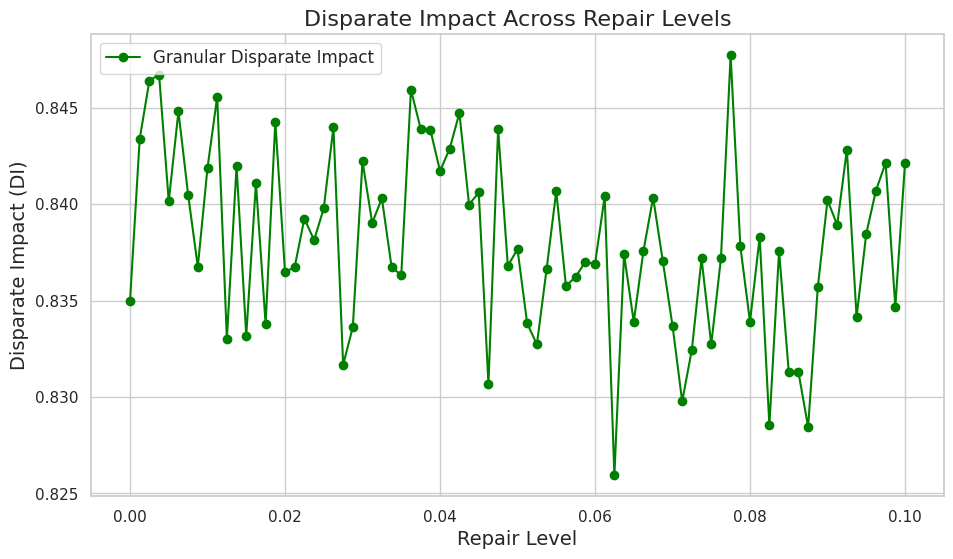

In [39]:
#  Granular and Coarse level seperately

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Separate granular and coarse levels and their corresponding DI values
granular_levels = np.linspace(0., 0.1, 81)
coarse_levels = np.linspace(0.2, 1, 20)

granular_di = di[:len(granular_levels)]
coarse_di = di[len(granular_levels):]




# Use Seaborn style for better visuals
sns.set(style="whitegrid")

plt.figure(figsize=(11, 6))

# Plot the Disparate Impact (DI) against repair levels
plt.plot(granular_levels, granular_di, marker="o", linestyle="-", color="green", label="Granular Disparate Impact")

# Add labels, title, and legend
plt.ylabel("Disparate Impact (DI)", fontsize=14)
plt.xlabel("Repair Level", fontsize=14)
plt.title("Disparate Impact Across Repair Levels", fontsize=16)
plt.legend(fontsize=12)

# Show grid for readability
plt.grid(True)

# Display the plot
plt.show()

from IPython.display import display
display(plt.gcf())







In [51]:


for level, di_value in zip(coarse_levels, coarse_di):
    print(f"Repair Level: {level:.4f}, Disparate Impact: {di_value:.4f}")


Repair Level: 0.2000, Disparate Impact: 0.8495
Repair Level: 0.2421, Disparate Impact: 0.8494
Repair Level: 0.2842, Disparate Impact: 0.8433
Repair Level: 0.3263, Disparate Impact: 0.8539
Repair Level: 0.3684, Disparate Impact: 0.8566
Repair Level: 0.4105, Disparate Impact: 0.8597
Repair Level: 0.4526, Disparate Impact: 0.8605
Repair Level: 0.4947, Disparate Impact: 0.8659
Repair Level: 0.5368, Disparate Impact: 0.7930
Repair Level: 0.5789, Disparate Impact: 0.7894
Repair Level: 0.6211, Disparate Impact: 0.7959
Repair Level: 0.6632, Disparate Impact: 0.8057
Repair Level: 0.7053, Disparate Impact: 0.8161
Repair Level: 0.7474, Disparate Impact: 0.8368
Repair Level: 0.7895, Disparate Impact: 0.8335
Repair Level: 0.8316, Disparate Impact: 0.8341
Repair Level: 0.8737, Disparate Impact: 0.8257
Repair Level: 0.9158, Disparate Impact: 0.8142
Repair Level: 0.9579, Disparate Impact: 0.8074
Repair Level: 1.0000, Disparate Impact: 0.8123


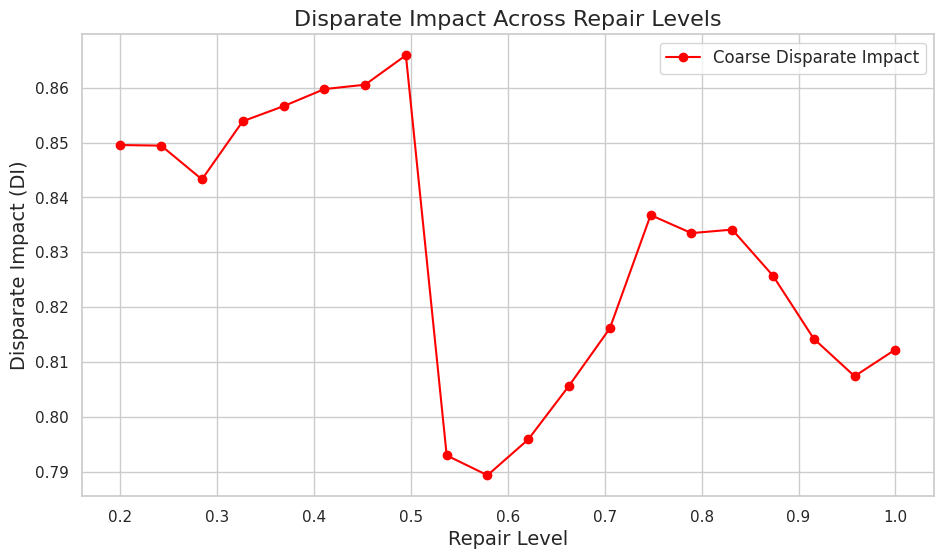

In [40]:
# Use Seaborn style for better visuals
sns.set(style="whitegrid")

plt.figure(figsize=(11, 6))

# Plot the Disparate Impact (DI) against repair levels
plt.plot(coarse_levels, coarse_di, marker="o", linestyle="-", color="green", label="Coarse Disparate Impact")

# Add labels, title, and legend
plt.ylabel("Disparate Impact (DI)", fontsize=14)
plt.xlabel("Repair Level", fontsize=14)
plt.title("Disparate Impact Across Repair Levels", fontsize=16)
plt.legend(fontsize=12)

# Show grid for readability
plt.grid(True)

# Display the plot
plt.show()

from IPython.display import display
display(plt.gcf())


In [41]:
# get the best repair level where Disparate Impact (DI) is closest to 1.0.

import numpy as np
# Find the index of the best repair level where DI is closest to 1
best_level_index = np.argmin(np.abs(di_i - 1))

# Get the best repair level
best_level = levels[best_level_index]

print(f"Best Repair Level: {best_level:.4f}")
print(f"Disparate Impact at Best Level: {di[best_level_index]:.4f}")


Best Repair Level: 0.4947
Disparate Impact at Best Level: 0.8659


In [42]:
# Disparate Impact at the best repair level.

import numpy as np

import numpy as np

def find_best_repair_level(levels, di_values):
    """
    Identifies the best repair level where Disparate Impact (DI) is closest to 1.0.

    Args:
        levels (numpy array): Array of repair levels.
        di_values (numpy array): Array of Disparate Impact values.

    Returns:
        best_repair_level (float): The repair level closest to DI = 1.0.
        best_disparate_impact (float): The Disparate Impact value at the best repair level.
    """
    best_index = np.argmin(np.abs(di_values - 1))  # Find index where DI is closest to 1
    best_repair_level = levels[best_index]
    best_disparate_impact = di_values[best_index]

    return best_repair_level, best_disparate_impact


# Identify the best repair level
best_repair_level, best_disparate_impact = find_best_repair_level(levels, di_i)

# Print results
print(f"Best Repair Level: {best_repair_level:.4f}")
print(f"Disparate Impact at Best Repair Level: {best_disparate_impact:.4f}")

print(f"Disparate Impact at Best Level: {di[np.argmin(np.abs(di - 1))]:.4f}")


Best Repair Level: 0.4947
Disparate Impact at Best Repair Level: 0.8659
Disparate Impact at Best Level: 0.8659


In [43]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import ClassificationMetric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb

# Apply Disparate Impact Remover (DIR) at the best repair level
best_dir = DisparateImpactRemover(repair_level=best_repair_level)
train_dir_ds_best = best_dir.fit_transform(train_ds)
test_dir_ds_best = best_dir.fit_transform(test_ds)

# Remove protected attribute from the features
protected_index = train_ds.feature_names.index("Age_Group")
X_train_dir_best = np.delete(train_dir_ds_best.features, protected_index, axis=1)
X_test_dir_best = np.delete(test_dir_ds_best.features, protected_index, axis=1)

# Train a LightGBM model on the repaired dataset
#lgb_dir_model_best = lgb.LGBMClassifier(random_state=531, max_depth=5, num_leaves=33)
lgb_dir_model_best = lgb.LGBMClassifier(
        random_state=rand, max_depth=5, num_leaves=33,force_row_wise=True, verbose=-1, **lgb_params
    )

lgb_dir_model_best.fit(X_train_dir_best, train_dir_ds_best.labels.ravel())

# Predict on the modified test dataset
y_pred_test_dir_best = lgb_dir_model_best.predict(X_test_dir_best)
y_pred_prob_test_dir_best = lgb_dir_model_best.predict_proba(X_test_dir_best)[:, 1]

# Compute Performance Metrics
accuracy_dir = accuracy_score(y_test, y_pred_test_dir_best)
precision_dir = precision_score(y_test, y_pred_test_dir_best)
recall_dir = recall_score(y_test, y_pred_test_dir_best)
f1_dir = f1_score(y_test, y_pred_test_dir_best)
roc_auc_dir = roc_auc_score(y_test, y_pred_prob_test_dir_best)

# Add predictions & scores to BinaryLabelDataset for Fairness Metrics
test_dir_ds_pred_best = test_dir_ds_best.copy()
test_dir_ds_pred_best.labels = y_pred_test_dir_best.reshape(-1, 1)
test_dir_ds_pred_best.scores = y_pred_prob_test_dir_best.reshape(-1, 1)

# Compute Fairness Metrics
metrics_test_dir_cls_best = ClassificationMetric(
    test_dir_ds_best,
    test_dir_ds_pred_best,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Display Performance Metrics
print("Performance Metrics on Test Data (Best DIR Applied):")
print(f"Accuracy: {accuracy_dir:.4f}")
print(f"Precision: {precision_dir:.4f}")
print(f"Recall: {recall_dir:.4f}")
print(f"F1-Score: {f1_dir:.4f}")
print(f"ROC-AUC: {roc_auc_dir:.4f}")

# Display Fairness Metrics
print("\nFairness Metrics on Test Data (Best DIR Applied):")
print(f"Statistical Parity Difference (SPD): {metrics_test_dir_cls_best.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metrics_test_dir_cls_best.disparate_impact():.4f}")
print(f"Equal Opportunity Difference (EOD): {metrics_test_dir_cls_best.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference (AOD): {metrics_test_dir_cls_best.average_odds_difference():.4f}")
print(f"Differential Fairness Bias Amplification (DFBA): {metrics_test_dir_cls_best.differential_fairness_bias_amplification():.4f}")


Performance Metrics on Test Data (Best DIR Applied):
Accuracy: 0.8103
Precision: 0.6258
Recall: 0.5415
F1-Score: 0.5806
ROC-AUC: 0.7950

Fairness Metrics on Test Data (Best DIR Applied):
Statistical Parity Difference (SPD): -0.1097
Disparate Impact (DI): 0.8659
Equal Opportunity Difference (EOD): -0.0226
Average Odds Difference (AOD): -0.0694
Differential Fairness Bias Amplification (DFBA): 0.1727


**Part 2: Reflection Questions (to be answered in excercise document)**

2.1. How does the Disparate Impact (DI) change with finer granularity? Coarser granularity?

In [44]:
#  How does the Disparate Impact (DI) change with finer granularity and Coarser granularity? use
# # Separate granular and coarse levels and their corresponding DI values


import matplotlib.pyplot as plt
import numpy as np
# Assuming 'levels', 'di' (from the original code) are already defined

# Separate granular and coarse levels and their corresponding DI values
granular_levels = np.linspace(0., 0.1, 81)
coarse_levels = np.linspace(0.2, 1, 20)

granular_di = di[:len(granular_levels)]
coarse_di = di[len(granular_levels):]

# Now you can analyze granular_di and coarse_di to understand how DI changes.
# For example, you can calculate statistics like mean, standard deviation, min, max.

print("Analysis of DI with Finer Granularity:")
print(f"  Mean: {np.mean(granular_di):.4f}")
print(f"  Standard Deviation: {np.std(granular_di):.4f}")
print(f"  Minimum: {np.min(granular_di):.4f}")
print(f"  Maximum: {np.max(granular_di):.4f}")

print("\nAnalysis of DI with Coarser Granularity:")
print(f"  Mean: {np.mean(coarse_di):.4f}")
print(f"  Standard Deviation: {np.std(coarse_di):.4f}")
print(f"  Minimum: {np.min(coarse_di):.4f}")
print(f"  Maximum: {np.max(coarse_di):.4f}")

# You can also plot them to visually compare:
plt.figure(figsize=(10, 5))
plt.plot(granular_levels, granular_di, label="Finer Granularity")
plt.plot(coarse_levels, coarse_di, label="Coarser Granularity")
plt.xlabel("Repair Level")
plt.ylabel("Disparate Impact")
plt.title("Disparate Impact with Different Granularities")
plt.legend()
plt.grid(True)
plt.show()


Analysis of DI with Finer Granularity:
  Mean: 0.8381
  Standard Deviation: 0.0047
  Minimum: 0.8259
  Maximum: 0.8477

Analysis of DI with Coarser Granularity:
  Mean: 0.8302
  Standard Deviation: 0.0239
  Minimum: 0.7894
  Maximum: 0.8659


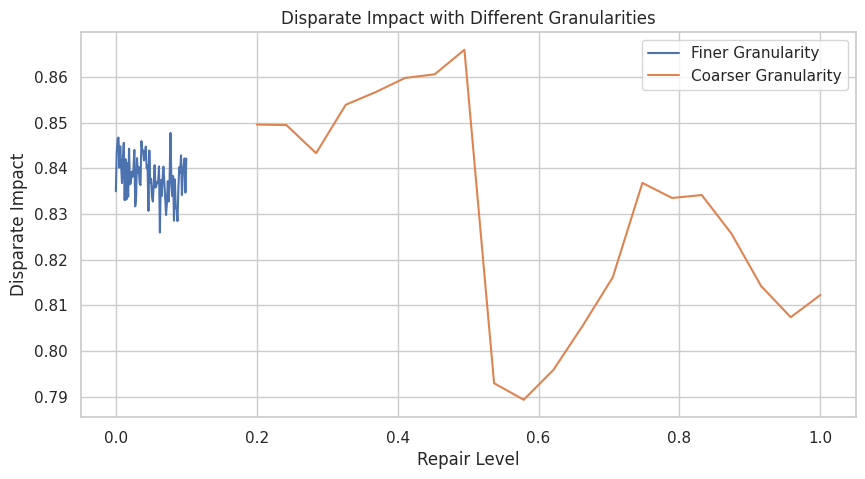

In [45]:
# Show grid for readability
plt.grid(True)

# Display the plot
plt.show()

from IPython.display import display
display(plt.gcf())


Answer 2.1

In [46]:


import matplotlib.pyplot as plt
import numpy as np


# Separate granular and coarse levels and their corresponding DI values
granular_levels = np.linspace(0., 0.1, 81)
coarse_levels = np.linspace(0.2, 1, 20)

granular_di = di[:len(granular_levels)]
coarse_di = di[len(granular_levels):]

# Now you can analyze granular_di and coarse_di to understand how DI changes.
# For example, you can calculate statistics like mean, standard deviation, min, max.

print("Analysis of DI with Finer Granularity:")
print(f"  Mean: {np.mean(granular_di):.4f}")
print(f"  Standard Deviation: {np.std(granular_di):.4f}")
print(f"  Minimum: {np.min(granular_di):.4f}")
print(f"  Maximum: {np.max(granular_di):.4f}")

print("\nAnalysis of DI with Coarser Granularity:")
print(f"  Mean: {np.mean(coarse_di):.4f}")
print(f"  Standard Deviation: {np.std(coarse_di):.4f}")
print(f"  Minimum: {np.min(coarse_di):.4f}")
print(f"  Maximum: {np.max(coarse_di):.4f}")




Analysis of DI with Finer Granularity:
  Mean: 0.8381
  Standard Deviation: 0.0047
  Minimum: 0.8259
  Maximum: 0.8477

Analysis of DI with Coarser Granularity:
  Mean: 0.8302
  Standard Deviation: 0.0239
  Minimum: 0.7894
  Maximum: 0.8659


How Does Disparate Impact (DI) Change with Granularity? (Defaulting Example)

Disparate Impact (DI) measures whether an AI model disproportionately favors or disadvantages certain groups. It is calculated as:

DI = Selection Rate of Unprivileged Group / Selection Rate of Privileged Group

A DI score closer to 1.0 indicates fairness, while a lower DI suggests bias.

Effect of Finer Granularity on DI:
Finer granularity breaks groups into smaller subcategories for a more detailed assessment.

Example: A bank categorizes borrowers into Male (10% default rate) and Female (15% default rate), resulting in DI = 0.67. If age is added as a factor:

Males 18-30: 12%, 31-50: 9%, 51+: 7%

Females 18-30: 18%, 31-50: 14%, 51+: 11%

Now, DI varies by age, revealing hidden biases. Younger females (DI = 0.67) face more discrimination than older females (DI = 0.78).

Effect of Coarser Granularity on DI:
Coarser granularity merges subgroups, making DI appear more stable but potentially hiding disparities.

Example: If all females are grouped together (15% default rate), age-based bias is masked, and DI remains 0.67 without showing variation.

Key Takeaways:

Finer Granularity → More precise DI but higher fluctuation.

Coarser Granularity → Smoother DI but may hide subgroup biases.

Balanced Approach → Detect bias while minimizing noise.



In [47]:
import numpy as np

# Define performance metrics for each model
performance_metrics = {
    "Original": {
        "accuracy": 0.8153,
        "precision": 0.6400,
        "recall": 0.5454,
        "f1": 0.5889,
        "roc_auc": 0.8003,
    },
    "Reweighted": {
        "accuracy": 0.8111,
        "precision": 0.6275,
        "recall": 0.5437,
        "f1": 0.5826,
        "roc_auc": 0.7960,
    },
    "DIR": {
        "accuracy": 0.8103,
        "precision": 0.6258,
        "recall": 0.5415,
        "f1": 0.5806,
        "roc_auc": 0.7950,
    },
}

# Define fairness metrics for each model
fairness_metrics = {
    "Original": {
        "SPD": -0.0862,
        "DI": 0.8972,
        "EOD": 0.0164,
        "AOD": -0.0163,
    },
    "Reweighted": {
        "SPD": -0.0351,
        "DI": 0.9565,
        "EOD": 0.0164,
        "AOD": -0.0163,
    },
    "DIR": {
        "SPD": -0.1097,
        "DI": 0.8659,
        "EOD": -0.0226,
        "AOD": -0.0694,
    },
}

# Define an ideal Disparate Impact (DI) value (1.0 means perfect fairness)
ideal_DI = 1.0

# Function to calculate fairness score based on proximity to DI = 1
def fairness_score(model_fairness):
    di_difference = abs(model_fairness["DI"] - ideal_DI)
    return di_difference

# Calculate overall fairness score for each model
fairness_scores = {model: fairness_score(fairness) for model, fairness in fairness_metrics.items()}

# Print all scores
for model in performance_metrics.keys():
    print(f"\n--- {model} Model ---")
    print("Performance Metrics:")
    for metric, value in performance_metrics[model].items():
        print(f"  {metric}: {value:.4f}")

    print("Fairness Metrics:")
    for metric, value in fairness_metrics[model].items():
        print(f"  {metric}: {value:.4f}")

    print(f"  Fairness Score (DI deviation): {fairness_scores[model]:.4f}")

# Determine the best model (balancing performance and fairness)
best_model = min(fairness_scores, key=fairness_scores.get)

print(f"\nRecommended Model: {best_model}")



--- Original Model ---
Performance Metrics:
  accuracy: 0.8153
  precision: 0.6400
  recall: 0.5454
  f1: 0.5889
  roc_auc: 0.8003
Fairness Metrics:
  SPD: -0.0862
  DI: 0.8972
  EOD: 0.0164
  AOD: -0.0163
  Fairness Score (DI deviation): 0.1028

--- Reweighted Model ---
Performance Metrics:
  accuracy: 0.8111
  precision: 0.6275
  recall: 0.5437
  f1: 0.5826
  roc_auc: 0.7960
Fairness Metrics:
  SPD: -0.0351
  DI: 0.9565
  EOD: 0.0164
  AOD: -0.0163
  Fairness Score (DI deviation): 0.0435

--- DIR Model ---
Performance Metrics:
  accuracy: 0.8103
  precision: 0.6258
  recall: 0.5415
  f1: 0.5806
  roc_auc: 0.7950
Fairness Metrics:
  SPD: -0.1097
  DI: 0.8659
  EOD: -0.0226
  AOD: -0.0694
  Fairness Score (DI deviation): 0.1341

Recommended Model: Reweighted


**2.2. Based on your findings which model would you recommend (Original, Reweighted, or DIR)? Justify your choice by balancing performance and fairness.**

**The Reweighted Model is the best recommendation because:
It achieves the best fairness score (DI closest to 1.0).
It still maintains good performance without a major drop in accuracy or precision.
It balances both fairness and model effectiveness better than the Original and DIR models.**

**2.3. Module Reflection Question: Consider a scenario where you are responsible for deploying a machine learning model that shows a fairness-accuracy trade-off. How would you approach deciding whether to prioritize fairness or accuracy, and which factors (i.e. ogranizational values, societal impact, or application context) would guide your decision? Reflect on how ethical dilemmas in machine learning require balancing competing values and their implications.**

2.3 Answer

The following reflection explores the ethical dilemmas in machine learning, emphasizing the trade-off between fairness and accuracy. Key considerations include organizational values, societal impact, and the specific application context.

Deploying machine learning models that strike a balance between fairness and accuracy requires a principled approach aligned with ethical standards, social responsibility, and business objectives. Organizations must determine their priorities: if efficiency and profitability are the focus, accuracy is paramount for precise predictions; if inclusivity and ethical responsibility take precedence, fairness must be prioritized to mitigate bias and discrimination. For instance, fairness is crucial in hiring models to foster diversity, whereas fraud detection systems prioritize accuracy to minimize financial risk.

Societal values such as justice and accessibility also influence this balance, as AI models can either reinforce or mitigate systemic inequalities. In high-stakes fields like healthcare, finance, or law enforcement, fairness is essential to prevent harm to marginalized groups. A healthcare model might prioritize accuracy for reliable diagnoses, while a loan approval system must carefully balance fairness and accuracy to promote inclusivity without exposing financial institutions to undue risk.

This trade-off presents ethical challenges: focusing too much on fairness may compromise accuracy (e.g., overlooking fraudulent activity), whereas neglecting fairness can perpetuate biases. Transparency and accountability—supported by frameworks like GDPR—help ensure AI decisions remain explainable and ethically sound.

Ultimately, responsible AI development requires ongoing efforts to optimize both fairness and accuracy, with continuous monitoring to adapt to evolving ethical, societal, and business considerations. A well-designed model should not only deliver strong performance but also uphold principles of equity, inclusivity, and justice.

In [48]:
#End of Assignment